#Announcement

I will carry over changes made in Part 1 that differ from video. I believe this will lead to replicable results but they will not match video given changes made.

Also note changes to Challenges.

<center>
<h1>Chapter 13 - Part 2</h1>
</center>

<hr>

Using the tensorflow library to build and tune ANNs. A complicated chapter that we will cover mostly at surface level. I'll try to give you links to deeper discussion.

##Set-up

First bring in your library.

In [1]:
github_name = 'marvnc'
repo_name = 'cs523'
source_file = 'library.py'
url = f'https://raw.githubusercontent.com/{github_name}/{repo_name}/main/{source_file}'
!rm $source_file
!wget $url
%run -i $source_file

rm: cannot remove 'library.py': No such file or directory
--2025-05-28 17:02:38--  https://raw.githubusercontent.com/marvnc/cs523/main/library.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48297 (47K) [text/plain]
Saving to: ‘library.py’

library.py          100%[===================>]  47.17K  --.-KB/s    in 0.01s   

2025-05-28 17:02:39 (3.12 MB/s) - ‘library.py’ saved [48297/48297]



In [2]:
url = 'https://raw.githubusercontent.com/fickas/asynch_models/main/datasets/titanic_trimmed.csv'  #trimmed version

titanic_trimmed = pd.read_csv(url)
titanic_trimmed.head()


,Age,Gender,Class,Joined,Married,Fare,Survived
0,41.0,Male,C3,Southampton,0.0,7.0,0
1,21.0,Male,Crew,Southampton,0.0,0.0,0
2,13.0,Male,C3,Southampton,NaN,20.0,0
3,16.0,Male,C3,Southampton,0.0,NaN,0
4,NaN,Male,C2,Cherbourg,0.0,24.0,0


In [3]:
len(titanic_trimmed)

1313

In [4]:
%%capture
x_train, x_test, y_train, y_test = titanic_setup(titanic_trimmed)

In [5]:
x_train[:1]  #[[ 0.78947368,  1.        ,  1.        ,  0.40075188,  0.        ,-0.26086957]]

array([[ 0.78947368,  1.        ,  1.        ,  0.40075188,  0.        ,
        -0.26086957]])

In [6]:
y_train[:1]

array([0])

#I. Review chapters

We will be running into concepts we have seen in past chapters. In particular, I would recommend reviewing these:

* Chapter 8 for gradient descent, learning rate, batch, epochs

* Chapter 9 for weight regularization

#II. We will use the tensorflow library to build (and tune) our ANNs

We began to explore tensorflow in the last chapter and noted a
major alternative would be PyTorch. I have not really used it but I have had students who say they like it. Concepts are same but syntax and methods different.

We will also use a sub-package of tensorflow called keras, which claims to add an easier front-end. I mostly agree, it does.

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_auc_score

###Now Jump through some hoops to get replicable results

I'm a little worried about this. Normally it works with straight ahead tensorflow. However we are introducing a tuning library later where I am concerned. If your results don't match up with mine, let me know. They should in theory.

In [8]:
tf.keras.utils.set_random_seed(1234)  #need this for replication
tf.config.experimental.enable_op_determinism()  #ditto - https://www.tensorflow.org/api_docs/python/tf/config/experimental/enable_op_determinism
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

##Ready to build an ANN

I am going to somewhat randomly chose to build an ANN that has two hidden layers. The first layer has 16 nodes and the second layer has 8 nodes. Other than that, it pretty much matches what we saw in the last chapter.

###I'm using a weight initializer

Again, I am skimming this topic but can point you to a [pretty good tutorial](https://towardsdatascience.com/weight-initialization-and-activation-functions-in-deep-learning-50aac05c3533). It discusses why we might want to use the `HeNormal` initializer to set the initial values of our weights on a layer.

<pre>
he_initializer = tf.keras.initializers.HeNormal(seed=1234)  #works well with our activation functions
</pre>

###I'm using a weight regularizer.

 We saw the need for this when looking at gradient descent and logistic regression (Chapter 9).
Remember that it penalizes weights that grow too large. The `L2` says we square the weights, i.e., really punish the large ones.

<pre>
l2_regu = tf.keras.regularizers.L2(0.01)  #weight regularization - tune the (reverse) lambda parameter
</pre>

###I'll chose `Relu` from last chapter as our activation function

Note I can use the string `'relu'`. Tensorflow has string short-cuts for some activation functions but not all. Depends if they have parameters or not. Relu does not.

In [9]:
act_fn = 'relu'  #long version: tf.keras.activations.relu()

###Not using Dropout to avoid nondeterminism

In [10]:
feature_n = x_train.shape[1]
feature_n

6

###We will need a way to turn strings into ints to use as seeds

In [11]:
import hashlib

def string_to_seed(string):
    # Create a hash of the string using SHA-256
    hash_object = hashlib.sha256(string.encode())
    # Convert first 8 bytes of hash to integer
    hash_int = int.from_bytes(hash_object.digest()[:8], 'big')
    return hash_int % (2**32 - 1)

###Build the model

In [12]:
ann_model = Sequential()

# Input layer
ann_model.add(Input(shape=(feature_n,), name="input_layer"))
#could add Dropout here but too few features to start with so bad idea

#hidden layer 1
layer_name = "hidden_layer_1"  #unique to each layer
ann_model.add(Dense(units=16,
                   activation=act_fn,
                   name=layer_name+'_dense',
                   kernel_regularizer=tf.keras.regularizers.l2(0.01),
                   kernel_initializer=tf.keras.initializers.HeNormal(seed=string_to_seed(layer_name+'_dense'))
))
#ann_model.add(Dropout(.2, name='dropout1', seed=string_to_seed('dropout1')))  #Dropout currently causes non-replicalbe results :(

#hidden layer 2
layer_name = "hidden_layer_2"
ann_model.add(Dense(units=8,
                   activation=act_fn,
                   name=layer_name+'_dense',
                   kernel_regularizer=tf.keras.regularizers.l2(0.01),
                   kernel_initializer=tf.keras.initializers.HeNormal(seed=string_to_seed(layer_name+'_dense'))
))
#ann_model.add(Dropout(.2, name='dropout2', seed=string_to_seed('dropout2')))

#could add more hidden layers if you wanted.

#hidden layer 3

#hidden layer 4

#etc

#output layer for binary classification
ann_model.add(Dense(units=1, name='output', activation='sigmoid'))  #only 1 node and using sigmoid (just like with logistic regression!)



##The model is now structured but not built

We have to compile it and provide some parameters:

* I'm going to continue to use `roc_auc` for scoring. This is consistent with what we have been using for other models.

* I considered using a special optimizer:
<pre>
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=.1),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
</pre>
The optimizer is a special version of Stochastic Gradient Descent. If you remember, we used partial differential equations to update the weights in Logistic Regression. Well, we do the same here! Do you remember the learning rate that was part of the weight-update formula? The twist I am adding here are several mechanisms that focus on that rate. They adjust it as epochs roll by. They look at how loss is changing. A simple example is they may increase the rate if they think we are in a divot (false minimum) to claw our way out. If they believe we are getting close to the minimum, they may decrease the rate. This is an open area of research. I'll give you a [discussion of the `Adam/ExponentialDecay` combo](https://stats.stackexchange.com/questions/200063/adam-optimizer-with-exponential-decay). Many others possible. But in end I thought it was overly complicated for our simple data so omitted it.

* For loss, Binary Crossentropy is the standard for binary classification problems. [Here is a pretty dang good tutorial](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a). I am using something called smoothing. I'll give you examples with and without:
<pre>
BCE = -[y * log(ŷ) + (1-y) * log(1-ŷ)]  #without smoothing
</pre>
where:
  - y is the true label (0 or 1)
  - ŷ is the model's prediction (between 0 and 1)

 With Label Smoothing (α):
<pre>
BCE = -[(y * (1-α) + α/2) * log(ŷ) + ((1-y) * (1-α) + α/2) * log(1-ŷ)]  #with smoothing
</pre>
where:
  - α is the smoothing parameter (like 0.1)
  - y is original label (0 or 1)
  - ŷ is model's prediction

 Example with α = 0.1:
  - For y = 1: (1 * 0.9 + 0.05) = 0.95
  - For y = 0: (0 * 0.9 + 0.05) = 0.05

 This smooths the labels from {0,1} to {0.05, 0.95}. This helps because:

  - It prevents the model from being overconfident
  - Makes training more stable since the model doesn't try to predict exact 0s and 1s
  - Can improve generalization by adding a small amount of uncertainty


In [13]:
ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=.1),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
                  metrics=['auc', 'accuracy']
)

###Code to test if we have replicable results



In [14]:
x_batch = x_train[:32]
y_batch = y_train[:32].reshape(-1, 1)

with tf.GradientTape() as tape:
    pred1 = ann_model(x_batch, training=True)
    loss1 = tf.keras.losses.binary_crossentropy(y_batch, pred1)
grads1 = tape.gradient(loss1, ann_model.trainable_variables)

with tf.GradientTape() as tape:
    pred2 = ann_model(x_batch, training=True)
    loss2 = tf.keras.losses.binary_crossentropy(y_batch, pred2)
grads2 = tape.gradient(loss2, ann_model.trainable_variables)

print("Gradients match:", all(np.array_equal(g1, g2) for g1, g2 in zip(grads1, grads2)))  #should be True if replicable

Gradients match: True


## Train an ANN

Ok, we now have a compiled model ready for training. We still have to decide on the batch size and the number of epochs. I am also going to use the callback we saw in last chapter. This allows me to set the epochs to a fairly large size knowing early stopping will cut things off if necessary.


In [15]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='auc',
    mode='max',
    min_delta=0,
    patience=15,  #Wait 15 epochs for loss to improve - if no decrease, stop
    verbose=0
)

In [16]:
batch = 32  #https://ai.stackexchange.com/questions/8560/how-do-i-choose-the-optimal-batch-size
epochs = 100  #mostly a guess
training = ann_model.fit(x=x_train,
                        y=y_train,
                         batch_size=batch,
                         epochs=epochs,
                         verbose=0,
                         callbacks=[early_stop_cb])

###Did we stop early?

In [17]:
batch, len(training.history['auc'])  #looks like no

(32, 100)

In [18]:
training.history['auc'][-1]  #0.8187116384506226

0.8187116384506226

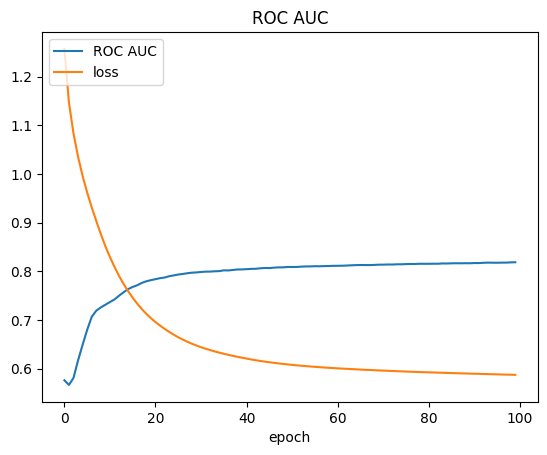

In [19]:
import matplotlib.pyplot as plt

plt.plot(training.history['auc'])
plt.plot(training.history['loss'])
plt.title('ROC AUC')
plt.xlabel('epoch')
plt.legend(['ROC AUC', 'loss'], loc='upper left')
plt.show()

##Evaluate on train set


###`predict` gives list of lists

In [20]:
yraw = ann_model.predict(x_train)[:,0]  #pull out prob of 1
yraw[:5]  #array([0.47342908, 0.31570902, 0.7469393 , 0.76173514, 0.21468766], dtype=float32)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([0.47342908, 0.31570902, 0.7469393 , 0.76173514, 0.21468766],
      dtype=float32)

In [21]:
binary = [1 if y>.5 else 0 for y in yraw]  #use normal threshold of .5
sum([x==y for x,y in zip(binary,y_train)])/len(binary)  #0.7438095238095238 accuracy on training set

np.float64(0.7438095238095238)

##Evaluate on test set

There is no `score` method. And `predict_proba` has been replaced with just `predict`. And `predict` just gives you probabilities of 1 (positive case).

In [22]:
yraw = ann_model.predict(x_test)[:,0]  #replaces predict_proba
yraw[:5]  #[0.5388105 , 0.7720659 , 0.8347173 , 0.22516692, 0.3030476 ]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


array([0.5388105 , 0.7720659 , 0.8347173 , 0.22516692, 0.3030476 ],
      dtype=float32)

In [23]:
result_df, fancy_df = threshold_results(np.round(np.arange(0.0,1.01,.05), 2), y_test, yraw)
fancy_df

,threshold,precision,recall,f1,auc,accuracy
0,0.00,0.43,1.00,0.60,0.79,0.43
1,0.05,0.43,1.00,0.60,0.79,0.43
2,0.10,0.43,1.00,0.60,0.79,0.43
3,0.15,0.45,0.99,0.62,0.79,0.47
4,0.20,0.47,0.94,0.62,0.79,0.51
5,0.25,0.51,0.91,0.66,0.79,0.59
6,0.30,0.59,0.87,0.70,0.79,0.68
7,0.35,0.62,0.79,0.69,0.79,0.70
8,0.40,0.66,0.71,0.68,0.79,0.71
9,0.45,0.70,0.61,0.65,0.79,0.71


#II. Getting ready for tuning

We cannot use sklearn HalvingSearchCV here, at least not directly.

It is more complicated, sigh.


##We need to package up ANN building

There are two approaches to tuning an ANN. One involves sklearn. The good news is that we should be able to use the same tuning method, halving search. The bad news is that tensorflow and sklearn are two different libraries. So we would have to employ yet a 3rd library to get them to talk together:

<pre>
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras
</pre>

I find this library confusing. Too many moving parts to glue things together. As an alternative, tensorflow has a tuner built just for it. The good news is we do not have to glue libraries together. The bad news it is still complicated to use. But I still find it slighly easier to use than `scikeras`.

In [24]:
#tuner library we will use
!pip install keras-tuner -q
import keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


###If we are going to tune we need choices

The obvious choices are how many layers and for each layer, how many nodes.
The one new choice I will add is for the activation function. I will do tuning on both relu (seen in last chapter) and leaky-relu. You can see below that the "leak" is for negative values - it does not map them automatically to 0 but gives them a small, scaled, negative contribution. This addresses a problem with relu, which has a tendency to eventually map all weights to 0, AKA the vanishing gradient. You cannot do learning with weights of 0.

<pre>
def leakyrelu(A,x):
  return A*x if x<0 else x
</pre>

###Add a new choice for activation function

<img src='https://www.dropbox.com/scl/fi/zbosbh712w3zd9daqbzj2/Screenshot-2023-09-26-at-4.38.30-PM.png?rlkey=cqjzxengplxm10ctog7jp82zw&raw=1'>


[More discussion on these choices among others](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/weight_initialization_activation_functions/#case-3-leaky-relu).

##Ok, here is where you need to buckle up

We need to define a function that will construct, compile and return an ANN model. The trick is, we will parameterize model building within the function body (as opposed to passing in a large parameter list).

The class `hp` comes with `keras_tuner` and stands for hyperparameters. What it gives us is a set of methods for laying out alternative choices. In essence, it replaces the `param_grid` we have been using up until now.

I think it is more confusing than the `param_grid`, but it is what is built-in to `keras_tuner`.

Let me show you a few things we will use in our new function:

<pre>
units=hp.Int(f"hidden_units{i}", min_value=min_units, max_value=max_units, step=step_units)
</pre>
This is the `Int` method. It allows you to set up choices. I suppose it would be a bit like using `range` in `param_grid` to set up choices. Notice I have to give it a name, i.e., "hidden_units{i}". The name has to be unique, hence I added the `{i}`. Here is the confusing part, at least to me: you cannot read it as literal code. You read it as when we are tuning, we will try various combinations of values. `Int` will give a different random value each time we take a tuning step (called a trial). So it is like `build` will be called over and over again, once for each tuning step. And we will get a random value each time it is called from this line of code.

##Need to build a class

The main workhorse is the `build` method. The constructor is used to set up bounds on our choices. Note that differs from video. Here, I am passing in bounds, whereas in the video, I had them hard-coded.

Notice that each layer is basically the same format with slight changes so I can use a loop to build them.

In [25]:
class MyHyperModel(keras_tuner.HyperModel):
  def __init__(self, n=6, metrics='auc',
                      layers=(1,5,1),   #1 to 5 by 1
                      units=(2,16,1),   #2 to 16 by 1
                      afn_list=('relu', 'leaky_relu')):
    self.n = n #number of features
    self.metrics = metrics
    self.units = units
    self.layers = layers
    self.afn_list = afn_list

  def build(self, hp):

    n = self.n
    metrics = self.metrics
    min_units = self.units[0]
    max_units = self.units[1]
    step_units = self.units[2]

    min_layers = self.layers[0]
    max_layers = self.layers[1]
    step_layers = self.layers[2]

    n_afns = len(self.afn_list)

    ann_model = Sequential()

    # Input layer
    ann_model.add(Input(shape=(n,), name="input_layer"))

    #add one or more new hidden layers
    layers = hp.Int("layers", min_value=min_layers, max_value=max_layers, step=step_layers)
    for i in range(layers):
      layer_name = f"hidden_layer_{i}"
      ann_model.add(Dense(
                  name=layer_name+'_dense',
                  kernel_regularizer=tf.keras.regularizers.l2(0.01),  #fixed but could be tuned
                  kernel_initializer=tf.keras.initializers.HeNormal(seed=string_to_seed(layer_name+'_dense')),

                  # Tune number of units.
                  units=hp.Int(f"hidden_units{i}", min_value=min_units, max_value=max_units, step=step_units),

                  # Tune the activation function to use.
                  activation= self.afn_list[hp.Int(f'afn{i}', min_value=0, max_value=n_afns-1, step=1)],
      ))

    #now output layer
    ann_model.add(Dense(units=1, activation='sigmoid'))

    ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=.1),  #fixed but could be tuned
                  optimizer=tf.keras.optimizers.Adam(learning_rate=.001),           #fixed but could be tuned
                  metrics=['auc', 'accuracy']
)
    return ann_model

##Discussion

In essence, the build method is called for each new trial, i.e., each new choice from the configurations. The hp choice methods randomly choose values.

I hope you can see where I am making choices by looking for the hp methods. Could I have made more choices? Sure. I could have chosen the  (reverse) lambda value. So up to you to decide how much you want to tune.

###Search space

I was trying roughly calculate how many unique configurations are possible with the build method above. My notes:

* Each layer has `15x2=30` configurations.

* There are 5 layers possible.

* I came up with `30**5=24,300,000`. Caveat: it is really more given I should be summing `30**1 + 30**2 + 30**3 + ...30**5` given the `layers` choice.

Yikes! That's a big space.

#Choice of search algorithm

Ok, we now have our model generator set up with choice points. So this is similar to having `param_grid` set up in prior chapters. The next question is how we want to search this space for best combos.
`keras_tuner` offers us 3 alternatives and one of them is similar to halving search: Hyperband. But I thought I would change things up a bit, and try a new search algorithm, random search. It's fairly simple. It randomly samples from all possible configurations. You tell it how many times to sample. It records the configuration that gives best results. If you say sample them all, then you have, in essence, grid search (24 million combinations).

The tradeoff is between how many to sample and how long you want to wait: the more you sample, the longer you wait.

I am choosing 40, which ends up about 10 minutes. Given 10 minutes is really not that long, I probably could have increased to a higher number. And if you were doing this for real, with this large a search space, you would tell your boss it's going to take days and she better give you extra computing power!

For a discussion that includes another available search algorithm provided by keras_tuner (described in the video), [see here](https://mikulskibartosz.name/using-hyperband-for-tensorflow-hyperparameter-tuning-with-keras-tuner).

In [26]:
tf.keras.utils.set_random_seed(1234)  #need this for replication

max_trials = 40 #a tough choice - larger is better but takes more time

hyper_tuner = keras_tuner.RandomSearch(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective('auc', 'max'),
    max_trials=max_trials,  #how many models to build, i.e., how many different configs to try
    executions_per_trial=1,  #given we have eliminated nondeterminism, can keep this at 1
    overwrite=True,
    #directory="ann/tb",  #for use by TensorBoard - discussed below
    seed=1234,
)

###An alternative to cross-validation

We cannot use cross-validation as with sklearn. We have to define our own folds and it can only be one fold! It is called the validation set. I am semi-arbitrarily carving off 250 rows from training to act as this validation set. The validation set is evaluated after every epoch. View it as a mini-test set but used during training.

In [27]:
x_train_tune = x_train[:-250]  #250/1050 roughly 20% - notice neither random nor stratified, kind of bad
x_train_val = x_train[-250:]
y_train_tune = y_train[:-250]
y_train_val = y_train[-250:]

If I was being more diligent about this, I would use `train_test_split` twice, once to carve out test set and then again to carve out validation set. Why is this better than what I have above? It will randomly sample and will stratify.

In [28]:
# Then add callbacks when calling search
callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_auc',              #auc during validation
            mode='max',
            patience=5,
            restore_best_weights=True),
        #keras.callbacks.TensorBoard("mlops/tb_logs"),  #for use by TensorBoard but slow!
    ]

Notice I changed metrics to monitor validation auc. This is standard practice. The validation set gives you a good picture of how you are doing.

##Under 10 minutes

In [29]:
%%capture
hyper_tuner.search(x_train_tune, y_train_tune,
                   epochs=100, batch_size=100,
                   validation_data=(x_train_val, y_train_val),
                   callbacks=callbacks,
                   )
tf.keras.backend.clear_session()  #get rid of unused models created during search

In [30]:
best_hp = hyper_tuner.get_best_hyperparameters()[0]
best_hp.values


{'layers': 3,
 'hidden_units0': 13,
 'afn0': 1,
 'hidden_units1': 15,
 'afn1': 1,
 'hidden_units2': 13,
 'afn2': 0,
 'hidden_units3': 13,
 'afn3': 1,
 'hidden_units4': 16,
 'afn4': 1}

###My results

<pre>
{'layers': 3,
 'hidden_units0': 13,
 'afn0': 1,
 'hidden_units1': 15,
 'afn1': 1,
 'hidden_units2': 13,
 'afn2': 0,
 'hidden_units3': 13,
 'afn3': 1,
 'hidden_units4': 16,
 'afn4': 1}
 </pre>

###Head scratcher

I read the above as finding 3 layers as the best. Yet we show unit results for 5 layers. It is one of the quirks of the keras tuner. It will actually generate a random selection for each `Int` generator before the loop even starts! I have read this decision is based on performance. It is faster to generate all random numbers possibly needed up front than do it incrementally. So we can ignore everything at `hidden_units3` and beyond.

###Video gives more details

Around minute 52 of the video I go into more detail on how keras tuner works behind the scenes, if you want a bit more on the rationale for this odd behavior.

##Train best model

We now have the best configuration out of the 40 we tried. It's relatively easy to now train a model using this configuration.

In [31]:
hypermodel = MyHyperModel()
model = hypermodel.build(best_hp)
training = model.fit(x_train, y_train, epochs=100, validation_data=(x_train_val, y_train_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                                      monitor='val_auc',
                                      mode='max',
                                      patience=15,
                                      restore_best_weights=True)
                   ])

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5575 - auc: 0.4671 - loss: 1.7010 - val_accuracy: 0.5480 - val_auc: 0.5265 - val_loss: 1.5061
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5651 - auc: 0.5121 - loss: 1.4924 - val_accuracy: 0.5480 - val_auc: 0.5428 - val_loss: 1.4047
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5560 - auc: 0.5254 - loss: 1.3977 - val_accuracy: 0.5760 - val_auc: 0.5726 - val_loss: 1.3317
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5760 - auc: 0.5559 - loss: 1.3251 - val_accuracy: 0.6200 - val_auc: 0.6030 - val_loss: 1.2697
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6043 - auc: 0.5930 - loss: 1.2621 - val_accuracy: 0.6360 - val_auc: 0.6315 - val_loss: 1.2148
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6463 - auc: 0.6301 - loss: 1.2056 - val_accuracy: 0.6320 - val_auc: 0.6646 - val_loss: 1.1645
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s

###I did not turn off verbose on purpose

I wanted to show you there is some value in watching epochs unfold. In particular, you should track training metrics (accuracy, auc, loss) with validation metrics (val_accuracy, val_auc, val_loss). The more they diverge, the more likely you are overfitting. For this run, I am quite pleased. Here is the last epoch:

<pre>
Epoch 100/100
accuracy: 0.7282 - auc: 0.8038 - loss: 0.6154 - val_accuracy: 0.7000 - val_auc: 0.7810 - val_loss: 0.6333
</pre>
It is almost always the case that validation metrics are worse than training. However, they are quite close here. I would be worried if validation was twice as bad or even worse. In that case, you would have to think about modifying your model to combat overfitting.

###We can check to make sure

From below, it does match up with what we expect at least in terms of `layers=3` and units.

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_0_dense (Dense)    │ (None, 13)             │            91 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1_dense (Dense)    │ (None, 15)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2_dense (Dense)    │ (None, 13)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,571 (6.14 KB)

 Trainable params: 523 (2.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,048 (4.10 KB)

In [33]:
len(training.history['auc'])  #100 - no early stopping

100

In [34]:
training.history['auc'][-1]  #0.8026094436645508

0.8026094436645508

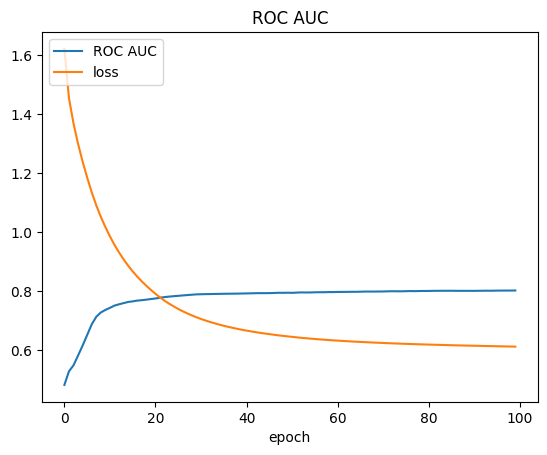

In [35]:
import matplotlib.pyplot as plt

plt.plot(training.history['auc'])
plt.plot(training.history['loss'])
plt.title('ROC AUC')
plt.xlabel('epoch')
plt.legend(['ROC AUC', 'loss'], loc='upper left')
plt.show()

###Check on test dataset

In [36]:
yraw = model.predict(x_test)[:,0]

yraw[:5]  #[0.6162435 , 0.7569884 , 0.8081401 , 0.21723291, 0.26127705]


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


array([0.6162435 , 0.7569884 , 0.8081401 , 0.21723291, 0.26127705],
      dtype=float32)

In [37]:
result_df, fancy_df = threshold_results(np.round(np.arange(0.0,1.01,.05), 2), y_test, yraw)
fancy_df

,threshold,precision,recall,f1,auc,accuracy
0,0.00,0.43,1.00,0.60,0.78,0.43
1,0.05,0.43,1.00,0.60,0.78,0.43
2,0.10,0.43,0.99,0.60,0.78,0.43
3,0.15,0.44,0.99,0.61,0.78,0.46
4,0.20,0.46,0.96,0.62,0.78,0.50
5,0.25,0.51,0.91,0.65,0.78,0.58
6,0.30,0.59,0.82,0.69,0.78,0.67
7,0.35,0.62,0.70,0.66,0.78,0.69
8,0.40,0.70,0.61,0.65,0.78,0.71
9,0.45,0.72,0.58,0.64,0.78,0.72


#TensorBoard

TensorBoard is a fancy way to visualize training and tuning. I have in essence shut it off by commenting out this line in tuning:

<pre>
#callbacks=[keras.callbacks.TensorBoard("mlops/tb_logs")]  #for use by TensorBoard
</pre>

Why? Because it seems to double the time tuning takes and we won't be using TensorBoard.

Why? I felt this chapter is already jam-packed with new libraries and did not want to stop and go over yet another.

That said, you can uncomment the line and then run the commands below to bring TensorBoard up if you want to play with it yourself.

Note you will get a "can't find folder" error for `%tensorboard` unless you uncomment my line.

More on use of [keras_tuner and TensorBoard](https://keras.io/guides/keras_tuner/visualize_tuning/).

In [38]:
#%load_ext tensorboard

In [39]:
#%tensorboard --logdir ann/tb_logs

#Challenge 1

Tune an ANN for customer dataset.

##Step 1.1 Bring in cable data

Divide out into features and labels.

In [40]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQPM6PqZXgmAHfRYTcDZseyALRyVwkBtKEo_rtaKq_C7T0jycWxH6QVEzTzJCRA0m8Vz0k68eM9tDm-/pub?output=csv'

In [41]:
customers_df = pd.read_csv(url)
customers_trimmed = customers_df.drop(columns='ID')  #this is a useless column which we will drop early
customers_trimmed = customers_trimmed.drop_duplicates(ignore_index=True)  #get rid of any duplicates
customers_trimmed.head()

,Gender,Experience Level,Time Spent,OS,ISP,Age,Rating
0,Female,medium,NaN,iOS,Xfinity,NaN,0
1,Male,medium,71.97,Android,Cox,50.0,0
2,Female,medium,101.81,NaN,Cox,49.0,1
3,Female,medium,86.37,Android,Xfinity,53.0,0
4,Female,medium,103.97,iOS,Xfinity,58.0,0


In [42]:
%%capture
x_train_cust, x_test_cust, y_train_cust,  y_test_cust = customer_setup(customers_trimmed)

In [43]:
x_train_cust.std(axis=0)  #[0.45875063, 0.43511254, 0.75411243, 0.45929552, 0.04987596, 0.62993528]

array([0.45875063, 0.43511254, 0.75411243, 0.45929552, 0.04987596,
       0.62993528])

##Step 1.2 Set up model builder

Parameterize `loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=.1)`. Include choices for `label_smoothing` `.1, .2, .3`.

###Here is original as a starting place

In [44]:
class MyHyperModel(keras_tuner.HyperModel):
  def __init__(self, n=6, metrics='auc',
                      layers=(1,5,1),
                      units=(2,16,1),
                      afn_list=('relu', 'leaky_relu')):
    self.n = n #number of features
    self.metrics = metrics
    self.units = units
    self.layers = layers
    self.afn_list = afn_list

  def build(self, hp):

    n = self.n
    metrics = self.metrics
    min_units = self.units[0]
    max_units = self.units[1]
    step_units = self.units[2]

    min_layers = self.layers[0]
    max_layers = self.layers[1]
    step_layers = self.layers[2]

    n_afns = len(self.afn_list)

    ann_model = Sequential()

    # Input layer
    ann_model.add(Input(shape=(n,), name="input_layer"))

    #add one or more new hidden layers
    layers = hp.Int("layers", min_value=min_layers, max_value=max_layers, step=step_layers)
    for i in range(layers):
      layer_name = f"hidden_layer_{i}"
      ann_model.add(Dense(
                  name=layer_name+'_dense',
                  kernel_regularizer=tf.keras.regularizers.l2(0.01),  #fixed but could be tuned
                  kernel_initializer=tf.keras.initializers.HeNormal(seed=string_to_seed(layer_name+'_dense')),

                  # Tune number of units.
                  units=hp.Int(f"hidden_units{i}", min_value=min_units, max_value=max_units, step=step_units),

                  # Tune the activation function to use.
                  activation= self.afn_list[hp.Int(f'afn{i}', min_value=0, max_value=n_afns-1, step=1)],
      ))

    #now output layer
    ann_model.add(Dense(units=1, activation='sigmoid'))

    ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=.1),  #fixed but could be tuned
                  optimizer=tf.keras.optimizers.Adam(learning_rate=.001),           #fixed but could be tuned
                  metrics=['auc', 'accuracy']
)
    return ann_model

###Now your new one

In [45]:
class CustomerHyperModel(keras_tuner.HyperModel):
  def __init__(self, n=6, metrics='auc',
                      layers=(1,5,1),
                      units=(2,16,1),
                      afn_list=('relu', 'leaky_relu'),
                      smoothing_list=(.1, .2, 0.3)
               ):
    self.n = n #number of features
    self.metrics = metrics
    self.units = units
    self.layers = layers
    self.afn_list = afn_list
    self.smoothing_list = smoothing_list

  def build(self, hp):

    n = self.n
    metrics = self.metrics
    min_units = self.units[0]
    max_units = self.units[1]
    step_units = self.units[2]

    min_layers = self.layers[0]
    max_layers = self.layers[1]
    step_layers = self.layers[2]

    n_afns = len(self.afn_list)

    ann_model = Sequential()

    # Input layer
    ann_model.add(Input(shape=(n,), name="input_layer"))

    #add one or more new hidden layers
    layers = hp.Int("layers", min_value=min_layers, max_value=max_layers, step=step_layers)
    for i in range(layers):
      layer_name = f"hidden_layer_{i}"
      ann_model.add(Dense(
                  name=layer_name+'_dense',
                  kernel_regularizer=tf.keras.regularizers.l2(0.01),  #fixed but could be tuned
                  kernel_initializer=tf.keras.initializers.HeNormal(seed=string_to_seed(layer_name+'_dense')),

                  # Tune number of units.
                  units=hp.Int(f"hidden_units{i}", min_value=min_units, max_value=max_units, step=step_units),

                  # Tune the activation function to use.
                  activation= self.afn_list[hp.Int(f'afn{i}', min_value=0, max_value=n_afns-1, step=1)],
      ))

    #now output layer
    ann_model.add(Dense(units=1, activation='sigmoid'))

    # Parameterize label smoothing

    smoothing = hp.Choice('smoothing', values=self.smoothing_list)

    ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=smoothing),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=.001),           #fixed but could be tuned
                  metrics=['auc', 'accuracy']
)
    return ann_model

##Step 2.2 Set up search

But bump trials to 50.

In [46]:
tf.keras.utils.set_random_seed(1234)  #need this for replication

max_trials = 50

hyper_tuner = keras_tuner.RandomSearch(
    hypermodel=CustomerHyperModel(),
    objective=keras_tuner.Objective('auc', 'max'),  #cannot use auc object as previously defined - have to use instance of keras_tuner.Objective class instead
    max_trials=max_trials,  #how many models to build, i.e., how many different configs to try
    executions_per_trial=1,  #given we have eliminated nondeterminism, can keep this at 1
    overwrite=True,
    #directory="ann/tb",  #for use by TensorBoard - discussed below
    seed=1234,
)

##Step 2.3 Create validation set

See how we did this for Titanic earlier in the notebook.

In [47]:
len(x_train_cust)

781

In [48]:
x_train_tune_cust = x_train_cust[:-150]  #150/1050 roughly 20% - notice not stratified
x_train_val_cust = x_train_cust[-150:]
y_train_tune_cust = y_train_cust[:-150]
y_train_val_cust = y_train_cust[-150:]

In [49]:
len(x_train_val_cust)  #150

150

##Step 2.4 Do the search

Get some coffee. Took me 28 minutes.

In [50]:
import datetime

In [51]:
%%capture
start = datetime.datetime.now()

hyper_tuner.search(x_train_tune_cust, y_train_tune_cust,
                   epochs=100, batch_size=32,
                   validation_data=(x_train_val_cust, y_train_val_cust),
                   #callbacks=[keras.callbacks.TensorBoard("mlops/tb_logs")]  #for use by TensorBoard
                   )
tf.keras.backend.clear_session()  #get rid of unused models created during search  #get rid of unused models created during search

end = datetime.datetime.now()
time_difference = end - start
difference_in_minutes = time_difference.total_seconds() / 60

In [52]:
print(f"The difference between the two datetimes is {difference_in_minutes} minutes.")  #28.3 minutes

The difference between the two datetimes is 25.96502931666667 minutes.


In [53]:
best_hp = hyper_tuner.get_best_hyperparameters()[0]
best_hp.values


{'layers': 4,
 'hidden_units0': 11,
 'afn0': 0,
 'smoothing': 0.1,
 'hidden_units1': 2,
 'afn1': 1,
 'hidden_units2': 14,
 'afn2': 1,
 'hidden_units3': 7,
 'afn3': 0,
 'hidden_units4': 15,
 'afn4': 0}

###My results

<pre>
{'layers': 4,
 'hidden_units0': 11,
 'afn0': 0,
 'smoothing': 0,
 'hidden_units1': 2,
 'afn1': 1,
 'hidden_units2': 14,
 'afn2': 1,
 'hidden_units3': 7,
 'afn3': 0,
 'hidden_units4': 15,
 'afn4': 0}
 </pre>

Reminder:  `hidden_units4` will be ignored given that `layers=4`.

##Step 2.5 Train best model

We now have the best configuration out of the 40 we tried. It's relatively easy to now train a model using this configuration.

In [54]:
hypermodel = CustomerHyperModel()
customer_model = hypermodel.build(best_hp)
training = customer_model.fit(x_train_tune_cust, y_train_tune_cust, epochs=100, validation_data=(x_train_val_cust, y_train_val_cust),
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                                      monitor='val_auc',
                                      mode='max',
                                      patience=15,
                                      restore_best_weights=True)
                   ])

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7224 - auc: 0.6641 - loss: 1.4575 - val_accuracy: 0.6600 - val_auc: 0.6382 - val_loss: 1.4291
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7212 - auc: 0.7085 - loss: 1.4104 - val_accuracy: 0.6800 - val_auc: 0.6615 - val_loss: 1.3859
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7347 - auc: 0.7246 - loss: 1.3638 - val_accuracy: 0.7000 - val_auc: 0.6760 - val_loss: 1.3442
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7429 - auc: 0.7350 - loss: 1.3178 - val_accuracy: 0.7200 - val_auc: 0.6877 - val_loss: 1.3048
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7620 - auc: 0.7476 - loss: 1.2736 - val_accuracy: 0.7133 - val_auc: 0.6996 - val_loss: 1.2679
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7664 - auc: 0.7605 - loss: 1.2314 - val_accuracy: 0.7267 - val_auc: 0.7199 - val_loss: 1.2312
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms

Looks pretty good in terms of training and validation results matching up. You should stop at epoch 51 with these results.

<pre>
Epoch 51/100
accuracy: 0.8693 - auc: 0.9170 - loss: 0.6197 - val_accuracy: 0.8333 - val_auc: 0.8691 - val_loss: 0.6612
</pre>

In [55]:
customer_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_0_dense (Dense)    │ (None, 11)             │            77 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1_dense (Dense)    │ (None, 2)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2_dense (Dense)    │ (None, 14)             │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3_dense (Dense)    │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770 (3.01 KB)

 Trainable params: 256 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 514 (2.01 KB)

In [56]:
len(training.history['auc'])  #51 - early stopping

51

In [57]:
training.history['auc'][-1]  #0.8929543495178223

0.8929543495178223

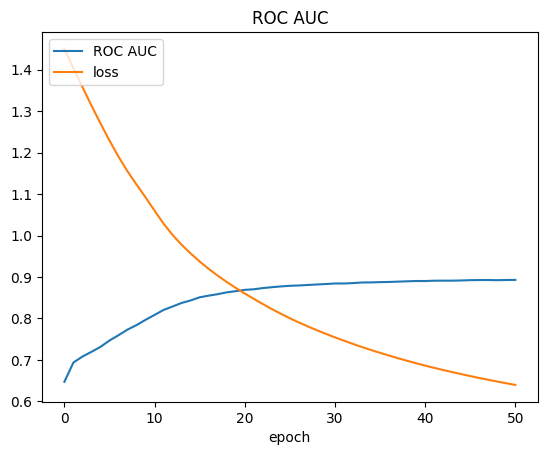

In [58]:
import matplotlib.pyplot as plt

plt.plot(training.history['auc'])
plt.plot(training.history['loss'])
plt.title('ROC AUC')
plt.xlabel('epoch')
plt.legend(['ROC AUC', 'loss'], loc='upper left')
plt.show()

##Step 2.6 Check on test dataset

In [59]:
yraw = customer_model.predict(x_test_cust)[:,0]

yraw[:5]  #[0.14100425, 0.15412292, 0.06318091, 0.81507254, 0.42360467]


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


array([0.14100425, 0.15412292, 0.06318091, 0.81507254, 0.42360467],
      dtype=float32)

In [60]:
result_df, fancy_df = threshold_results(np.round(np.arange(0.0,1.01,.05), 2), y_test_cust, yraw)
fancy_df

,threshold,precision,recall,f1,auc,accuracy
0,0.00,0.32,1.00,0.49,0.88,0.32
1,0.05,0.33,1.00,0.49,0.88,0.34
2,0.10,0.34,1.00,0.50,0.88,0.36
3,0.15,0.44,0.95,0.60,0.88,0.60
4,0.20,0.56,0.90,0.69,0.88,0.74
5,0.25,0.65,0.83,0.73,0.88,0.80
6,0.30,0.77,0.73,0.75,0.88,0.84
7,0.35,0.80,0.68,0.74,0.88,0.84
8,0.40,0.81,0.67,0.73,0.88,0.84
9,0.45,0.82,0.59,0.69,0.88,0.83


In [61]:
result_df

,threshold,precision,recall,f1,auc,accuracy
0,0.00,0.32,1.00,0.49,0.88,0.32
1,0.05,0.33,1.00,0.49,0.88,0.34
2,0.10,0.34,1.00,0.50,0.88,0.36
3,0.15,0.44,0.95,0.60,0.88,0.60
4,0.20,0.56,0.90,0.69,0.88,0.74
5,0.25,0.65,0.83,0.73,0.88,0.80
6,0.30,0.77,0.73,0.75,0.88,0.84
7,0.35,0.80,0.68,0.74,0.88,0.84
8,0.40,0.81,0.67,0.73,0.88,0.84
9,0.45,0.82,0.59,0.69,0.88,0.83


###My results

<img src='https://www.dropbox.com/scl/fi/gjiho9yw1nh7g4wf3y6z1/Screenshot-2025-05-16-at-9.39.03-AM.png?rlkey=szclvo6r0upif3tv1a4lli0da&raw=1' height = 500>

#Challenge 2

Explore a bit more tuning.


##Step 2.1 Change the model builder class

You can see the original at the start of Challenge 1, same one we used earlier in the notebook.

1. Rework layers to between 2 and 5, i.e., remove 1.
2. Rework units to between 4 and 16, i.e., remove 2 and 3.
3. Parameterize `tf.keras.regularizers.l2(0.01)`. Use as choices .005, .01, .05.
4. Skip tuning smoothing.

In [62]:
class MyHyperModel_v2(keras_tuner.HyperModel):
  def __init__(self, n=6, metrics='auc',
                      layers=(3,5,1),
                      units=(4,16,1),
                      afn_list=('relu', 'leaky_relu'),
                      l2_list=(0.005, 0.01, 0.05)
                      ):
    self.n = n #number of features
    self.metrics = metrics
    self.units = units
    self.layers = layers
    self.afn_list = afn_list
    self.l2_list = l2_list

  def build(self, hp):

    n = self.n
    metrics = self.metrics
    min_units = self.units[0]
    max_units = self.units[1]
    step_units = self.units[2]

    min_layers = self.layers[0]
    max_layers = self.layers[1]
    step_layers = self.layers[2]

    n_afns = len(self.afn_list)
    n_l2 = len(self.l2_list)

    ann_model = Sequential()

    # Input layer
    ann_model.add(Input(shape=(n,), name="input_layer"))

    #add one or more new hidden layers
    layers = hp.Int("layers", min_value=min_layers, max_value=max_layers, step=step_layers)
    for i in range(layers):
      layer_name = f"hidden_layer_{i}"
      ann_model.add(Dense(
                  name=layer_name+'_dense',
                  kernel_regularizer=tf.keras.regularizers.l2(hp.Choice(f'reg_lr{i}', values=self.l2_list)),
                  kernel_initializer=tf.keras.initializers.HeNormal(seed=string_to_seed(layer_name+'_dense')),

                  # Tune number of units.
                  units=hp.Int(f"hidden_units{i}", min_value=min_units, max_value=max_units, step=step_units),

                  # Tune the activation function to use.
                  activation= self.afn_list[hp.Int(f'afn{i}', min_value=0, max_value=n_afns-1, step=1)],
      ))

    #now output layer
    ann_model.add(Dense(units=1, activation='sigmoid'))

    ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=.1),  #fixed but could be tuned
                  optimizer=tf.keras.optimizers.Adam(learning_rate=.001),           #fixed but could be tuned
                  metrics=['auc', 'accuracy']
)
    return ann_model

##Step 2.2 Set up search

But bump trials to 100.

In [63]:
tf.keras.utils.set_random_seed(1234)  #need this for replication

max_trials = 100

hyper_tuner = keras_tuner.RandomSearch(
    hypermodel=MyHyperModel_v2(),
    objective=keras_tuner.Objective('auc', 'max'),  #cannot use auc object as previously defined - have to use instance of keras_tuner.Objective class instead
    max_trials=max_trials,  #how many models to build, i.e., how many different configs to try
    executions_per_trial=1,  #given we have eliminated nondeterminism, can keep this at 1
    overwrite=True,
    #directory="ann/tb",  #for use by TensorBoard
    seed=1234,
)

##Step 2.3 Check on validation set

If it is not defined, you will have to execute the code again in previous portion of notebook.

In [64]:
len(x_train_val)  #250

250

##Step 2.4 Do the search

Get some coffee. Took me 56 minutes.

In [65]:
%%capture
start = datetime.datetime.now()

hyper_tuner.search(x_train_tune, y_train_tune,
                   epochs=100, batch_size=32,
                   validation_data=(x_train_val, y_train_val),
                   #callbacks=[keras.callbacks.TensorBoard("mlops/tb_logs")]  #for use by TensorBoard
                   )
tf.keras.backend.clear_session()  #get rid of unused models created during search  #get rid of unused models created during search

end = datetime.datetime.now()
time_difference = end - start
difference_in_minutes = time_difference.total_seconds() / 60

In [66]:
print(f"The difference between the two datetimes is {difference_in_minutes} minutes.")  #56.17 minutes

The difference between the two datetimes is 57.71595335 minutes.


In [67]:
best_hp = hyper_tuner.get_best_hyperparameters()[0]
best_hp.values


{'layers': 5,
 'reg_lr0': 0.005,
 'hidden_units0': 16,
 'afn0': 0,
 'reg_lr1': 0.005,
 'hidden_units1': 5,
 'afn1': 0,
 'reg_lr2': 0.005,
 'hidden_units2': 11,
 'afn2': 1,
 'reg_lr3': 0.01,
 'hidden_units3': 4,
 'afn3': 1,
 'reg_lr4': 0.005,
 'hidden_units4': 5,
 'afn4': 1}

###My results

<pre>
{'layers': 4,
 'reg_lr0': 0,
 'hidden_units0': 10,
 'afn0': 0,
 'reg_lr1': 0,
 'hidden_units1': 4,
 'afn1': 0,
 'reg_lr2': 1,
 'hidden_units2': 12,
 'afn2': 0,
 'reg_lr3': 1,
 'hidden_units3': 15,
 'afn3': 0,
 'reg_lr4': 2,
 'hidden_units4': 12,
 'afn4': 0}
 </pre>

##Step 2.5 Train best model

We now have the best configuration out of the 100 we tried. It's relatively easy to now train a model using this configuration.

In [68]:
hypermodel = MyHyperModel_v2()
model = hypermodel.build(best_hp)
training = model.fit(x_train, y_train, epochs=100, validation_data=(x_train_val, y_train_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                                      monitor='val_auc',
                                      mode='max',
                                      patience=15,
                                      restore_best_weights=True)
                   ])

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4429 - auc: 0.6328 - loss: 1.1756 - val_accuracy: 0.4760 - val_auc: 0.6607 - val_loss: 1.1353
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4969 - auc: 0.6885 - loss: 1.1242 - val_accuracy: 0.5960 - val_auc: 0.6839 - val_loss: 1.0967
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6336 - auc: 0.7215 - loss: 1.0865 - val_accuracy: 0.6720 - val_auc: 0.6912 - val_loss: 1.0628
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6802 - auc: 0.7305 - loss: 1.0534 - val_accuracy: 0.6760 - val_auc: 0.7010 - val_loss: 1.0318
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7042 - auc: 0.7263 - loss: 1.0226 - val_accuracy: 0.6920 - val_auc: 0.7006 - val_loss: 1.0010
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7060 - auc: 0.7338 - loss: 0.9906 - val_accuracy: 0.6960 - val_auc: 0.6995 - val_loss: 0.9709
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms

###Still looking good in terms of overfitting

Train and validation scores roughly the same.

<pre>
Epoch 100/100
 accuracy: 0.7632 - auc: 0.8295 - loss: 0.6067 - val_accuracy: 0.7640 - val_auc: 0.8169 - val_loss: 0.6165
</pre>

In [69]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_0_dense (Dense)    │ (None, 16)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1_dense (Dense)    │ (None, 5)              │            85 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2_dense (Dense)    │ (None, 11)             │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3_dense (Dense)    │ (None, 4)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_4_dense (Dense)    │ (None, 5)              │            25 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,028 (4.02 KB)

 Trainable params: 342 (1.34 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 686 (2.68 KB)

In [70]:
len(training.history['auc'])  #100 - no early stopping

100

In [71]:
training.history['auc'][-1]  #0.8220989108085632

0.8292962312698364

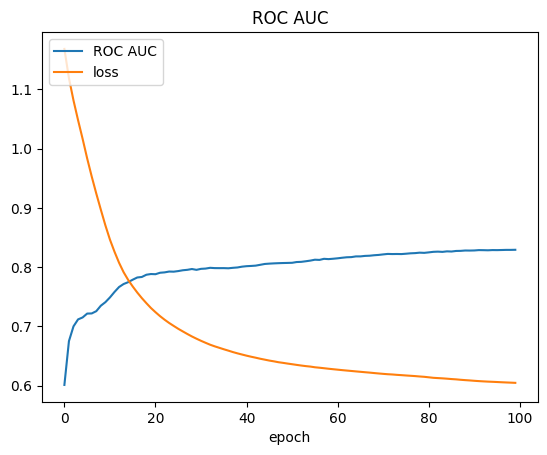

In [72]:
import matplotlib.pyplot as plt

plt.plot(training.history['auc'])
plt.plot(training.history['loss'])
plt.title('ROC AUC')
plt.xlabel('epoch')
plt.legend(['ROC AUC', 'loss'], loc='upper left')
plt.show()

##Step 2.6 Check on test dataset

In [73]:
yraw = model.predict(x_test)[:,0]

yraw[:5]  #[0.52119124, 0.75168633, 0.8782108 , 0.2019367 , 0.32780498]


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


array([0.40170518, 0.7951781 , 0.8718802 , 0.15905608, 0.24956107],
      dtype=float32)

In [74]:
result_df, fancy_df = threshold_results(np.round(np.arange(0.0,1.01,.05), 2), y_test, yraw)
fancy_df

,threshold,precision,recall,f1,auc,accuracy
0,0.00,0.43,1.00,0.60,0.80,0.43
1,0.05,0.43,1.00,0.60,0.80,0.43
2,0.10,0.43,1.00,0.60,0.80,0.43
3,0.15,0.45,0.98,0.62,0.80,0.48
4,0.20,0.53,0.91,0.67,0.80,0.62
5,0.25,0.59,0.86,0.70,0.80,0.68
6,0.30,0.62,0.75,0.68,0.80,0.69
7,0.35,0.65,0.73,0.69,0.80,0.71
8,0.40,0.68,0.68,0.68,0.80,0.72
9,0.45,0.76,0.57,0.65,0.80,0.74


In [75]:
result_df

,threshold,precision,recall,f1,auc,accuracy
0,0.00,0.43,1.00,0.60,0.8,0.43
1,0.05,0.43,1.00,0.60,0.8,0.43
2,0.10,0.43,1.00,0.60,0.8,0.43
3,0.15,0.45,0.98,0.62,0.8,0.48
4,0.20,0.53,0.91,0.67,0.8,0.62
5,0.25,0.59,0.86,0.70,0.8,0.68
6,0.30,0.62,0.75,0.68,0.8,0.69
7,0.35,0.65,0.73,0.69,0.8,0.71
8,0.40,0.68,0.68,0.68,0.8,0.72
9,0.45,0.76,0.57,0.65,0.8,0.74


###My results

|index|threshold|precision|recall|f1|accuracy|auc|
|---|---|---|---|---|---|---|
|0|0\.0|0\.43|1\.0|0\.6|0\.43|0\.79|
|1|0\.05|0\.43|1\.0|0\.6|0\.43|0\.79|
|2|0\.1|0\.44|1\.0|0\.61|0\.44|0\.79|
|3|0\.15|0\.46|0\.96|0\.63|0\.5|0\.79|
|4|0\.2|0\.5|0\.93|0\.65|0\.57|0\.79|
|5|0\.25|0\.55|0\.89|0\.68|0\.64|0\.79|
|6|0\.3|0\.61|0\.82|0\.7|0\.69|0\.79|
|7|0\.35|0\.64|0\.76|0\.7|0\.71|0\.79|
|8|0\.4|0\.69|0\.63|0\.66|0\.71|0\.79|
|9|0\.45|0\.7|0\.54|0\.61|0\.7|0\.79|
|10|0\.5|0\.77|0\.52|0\.62|0\.72|0\.79|
|11|0\.55|0\.81|0\.48|0\.6|0\.73|0\.79|
|12|0\.6|0\.91|0\.45|0\.6|0\.74|0\.79|
|13|0\.65|0\.92|0\.41|0\.57|0\.73|0\.79|
|14|0\.7|0\.91|0\.38|0\.53|0\.71|0\.79|
|15|0\.75|0\.91|0\.34|0\.5|0\.7|0\.79|
|16|0\.8|0\.9|0\.23|0\.36|0\.65|0\.79|
|17|0\.85|0\.92|0\.21|0\.34|0\.65|0\.79|
|18|0\.9|0\.83|0\.04|0\.08|0\.58|0\.79|
|19|0\.95|0\.0|0\.0|0\.0|0\.57|0\.79|
|20|1\.0|0\.0|0\.0|0\.0|0\.57|0\.79|

##Step 2.7 Save your model and threshold table

We will need them later. Eventually get them on GitHub.

In [76]:
model.save('ann_model.keras')
model2 = tf.keras.models.load_model('ann_model.keras') #load back in

In [77]:
result_df.to_csv('ann_thresholds.csv', index=False)